<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/FLNN%2BGA-PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Resource Utilization Prediction Model for Cloud Data Centers Using Evolutionary Algorithms and Machine Learning Techniques
GA: 로컬 최소 탈출 → 더 다양한 후보 탐색

Particle Swarm Optimization (PSO): 빠른 수렴 Adam 대신 GA-PSO로 가중치 진화 최적화

FLNN(Functional Link Neural Network): 입력 데이터에 대해 비선형 함수를 적용하여 새로운 feature 생성함으로써 비선형 문제를 해결

FLNN으로 예측을 하고 예측할때쓰는 가중치를 GA-PSO로 결정하는 구조!!

결과: Adam으로 학습한 CNN-LSTM보다 MAE 20~30% 감소 (논문 기준)

In [2]:
!pip install numpy deap pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.6 MB/s eta 0:00:00


/tmp/ipython-input-17-3492723336.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
2025-07-24 06:40:40,745 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}


입력 X shape: (8634, 5) 출력 y shape: (8634,)
MAE for GA: 0.8924252841925339


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.683
2025-07-24 06:40:41,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.683344845988043, best pos: [ 0.14256068  0.23469107 -0.81478455  0.61596125  0.82170304  0.00496089]


MAE for PSO: 0.683344845988043


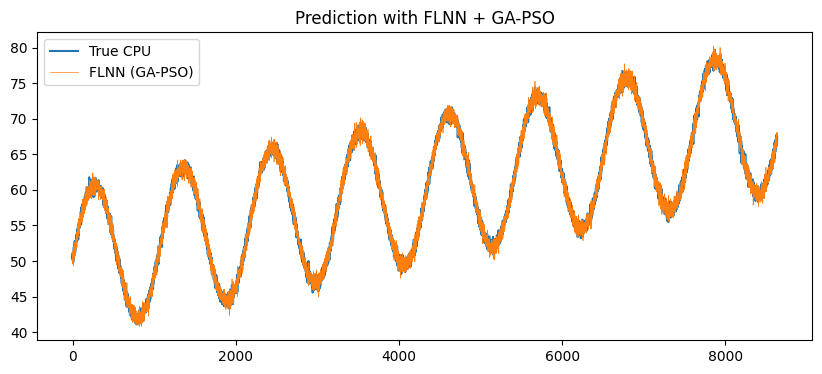

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# CPU data
np.random.seed(42)
days = 30
points_per_day = 24 * 12  # 하루 288 포인트 (5분 단위)
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# sliding window(1)
past_steps = 5
future_steps = 1

# sequence for data
X, y = [], []
for i in range(len(cpu)-past_steps-future_steps):
    X.append(cpu[i:i+past_steps])
    y.append(cpu[i+past_steps: i+past_steps+future_steps])
X = np.array(X)
y = np.array(y).flatten()

print("입력 X shape:", X.shape, "출력 y shape:", y.shape)

# FLNN 예측 : 입력 x에 대해 가중치 적용
def flnn_predict(weights, X):
    bias = weights[-1]
    return np.dot(X, weights[:-1]) + bias

from deap import base, creator, tools, algorithms

input_dim = past_steps
pop_size = 20
num_generations = 10

# 적합도: MAE 최소화
def eval_mae(individual):
    y_pred = flnn_predict(np.array(individual), X)
    return (np.abs(y - y_pred).mean(),)  # 튜플 반환해야 함

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=input_dim+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_mae)

pop = toolbox.population(n=pop_size)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

# GA
best_ga = tools.selBest(pop, 1)[0]
print("MAE for GA:", eval_mae(best_ga)[0])

import pyswarms as ps

def pso_objective(w):
    # w: (num_particles, num_weights)
    losses = []
    for particle in w:
        y_pred = flnn_predict(particle, X)
        losses.append(np.abs(y - y_pred).mean())
    return np.array(losses)

# initial PSO
num_particles = 20
num_weights = input_dim + 1  # past_steps + bias

x_init = np.tile(best_ga, (num_particles, 1)) + np.random.normal(0, 0.1, (num_particles, num_weights))

options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

optimizer = ps.single.GlobalBestPSO(
    n_particles=num_particles,
    dimensions=num_weights,
    options=options,
    init_pos=x_init
)

best_cost, best_pso = optimizer.optimize(pso_objective, iters=100)

print("MAE for PSO:", best_cost)

import matplotlib.pyplot as plt

# GA + PSO 함께 적용
final_weights = best_pso
y_pred = flnn_predict(final_weights, X)

plt.figure(figsize=(10,4))
plt.plot(y, label="True CPU")
plt.plot(y_pred, label="FLNN (GA-PSO)",linewidth = 0.5)
plt.legend()
plt.title("Prediction with FLNN + GA-PSO")
plt.show()


Result for Moving Average
MAE : 0.5516%
RMSE: 0.6882%

Aligned GA-PSO
MAE : 0.7000%
RMSE: 0.8810%


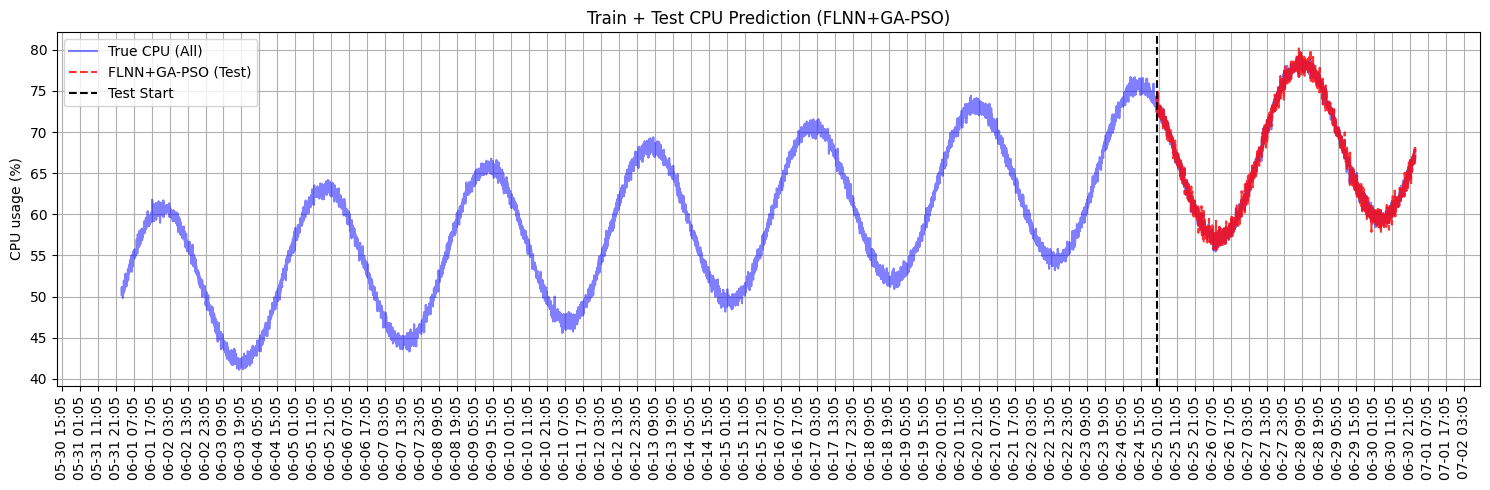

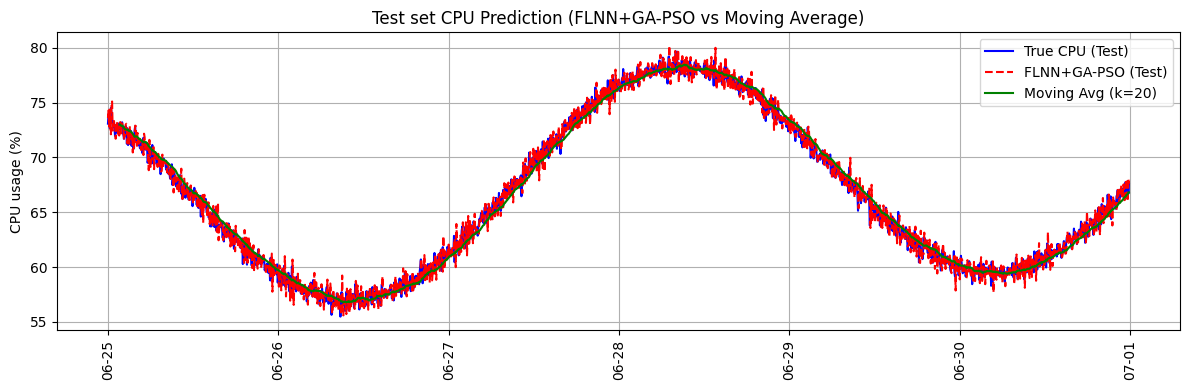

In [27]:
split_ratio = 0.8
split_idx = int(len(y) * split_ratio)

# Train, Test split
train_true = y[:split_idx]
test_true  = y[split_idx:]
train_pred = y_pred[:split_idx]
test_pred  = y_pred[split_idx:]

# time index
time_index_all = df.index[past_steps : past_steps + len(y)]
train_time_index = time_index_all[:split_idx]
test_time_index  = time_index_all[split_idx:]

# 7. Evaluation

k = 20
ma_pred = [np.mean(test_true[i-k:i]) for i in range(k, len(test_true))]
ma_true_vals = test_true[k:]
mae_ma  = mean_absolute_error(ma_true_vals, ma_pred)
rmse_ma = np.sqrt(mean_squared_error(ma_true_vals, ma_pred))
print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}%")
print(f"RMSE: {rmse_ma:.4f}%")

mae_ga_pso_aligned  = mean_absolute_error(aligned_test_true, aligned_test_pred)
rmse_ga_pso_aligned = np.sqrt(mean_squared_error(aligned_test_true, aligned_test_pred))
print("\nAligned GA-PSO")
print(f"MAE : {mae_ga_pso_aligned:.4f}%")
print(f"RMSE: {rmse_ga_pso_aligned:.4f}%")

# mae_ga_pso  = mean_absolute_error(test_true, test_pred)
# rmse_ga_pso = np.sqrt(mean_squared_error(test_true, test_pred))
# print("\nResult for FLNN+GA-PSO")
# print(f"MAE : {mae_ga_pso:.4f}%")
# print(f"RMSE: {rmse_ga_pso:.4f}%")

plt.figure(figsize=(15,5))

plt.plot(time_index_all, y, label="True CPU (All)", color="blue", alpha=0.5)
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--", alpha=0.8)

# start line for test datset
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")

# x축 legend 시간 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.ylabel("CPU usage (%)")
plt.title("Train + Test CPU Prediction (FLNN+GA-PSO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# test data 부분만 따로 plot
plt.figure(figsize=(12,4))
plt.plot(test_time_index, test_true, label="True CPU (Test)", color="blue")
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--")
plt.plot(test_time_index[k:], ma_pred, label=f"Moving Avg (k={k})", color="green", linestyle="-", linewidth = 1.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.ylabel("CPU usage (%)")
plt.title("Test set CPU Prediction (FLNN+GA-PSO vs Moving Average)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

aligned_test_pred = test_pred[k:]
aligned_test_true = test_true[k:]





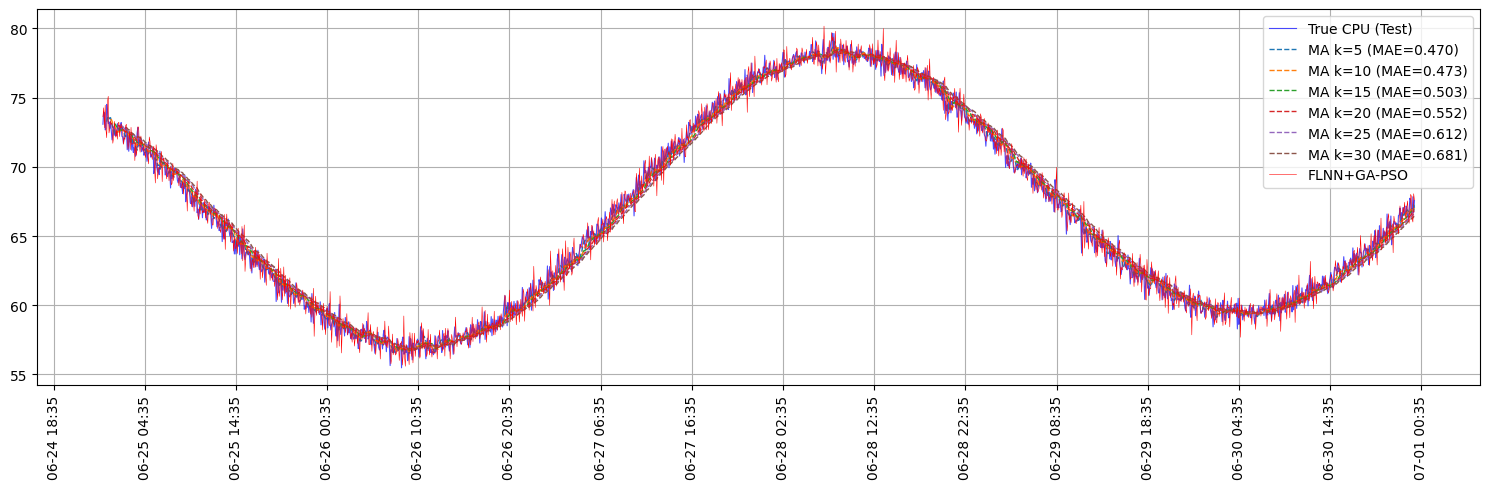

=== Moving Average 성능 비교 ===
k= 5  MAE=0.4695  RMSE=0.5886
k=10  MAE=0.4730  RMSE=0.5959
k=15  MAE=0.5033  RMSE=0.6328
k=20  MAE=0.5516  RMSE=0.6882
k=25  MAE=0.6119  RMSE=0.7565
k=30  MAE=0.6810  RMSE=0.8302


In [29]:
# MA 간격 조절
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # MAE/RMSE 저장 리스트

plt.figure(figsize=(15,5))
plt.plot(test_time_index, test_true, label="True CPU (Test)", color="blue", alpha=0.7, linewidth=0.8)

for k in k_list:
    # Moving Average 계산
    ma_pred = []
    for i in range(k, len(test_true)):
        ma_pred.append(np.mean(test_true[i-k:i]))

    # Series 생성 (index 맞춤)
    ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

    # 성능 측정 (동일 구간만 비교)
    true_vals_ma = test_true[k:]  # k step 이후만 비교
    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # 저장
    results.append((k, mae, rmse))

    # 그래프에 추가
    plt.plot(ma_pred_series, label=f"MA k={k} (MAE={mae:.3f})", linestyle="--", linewidth=1)

# ✅ GA-PSO 예측도 같이 비교
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO", color="red", linewidth=0.4)

# ✅ X축 tick: 600분(10시간) 간격
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ k별 성능 출력
print("=== Moving Average 성능 비교 ===")
for k, mae, rmse in results:
    print(f"k={k:2d}  MAE={mae:.4f}  RMSE={rmse:.4f}")


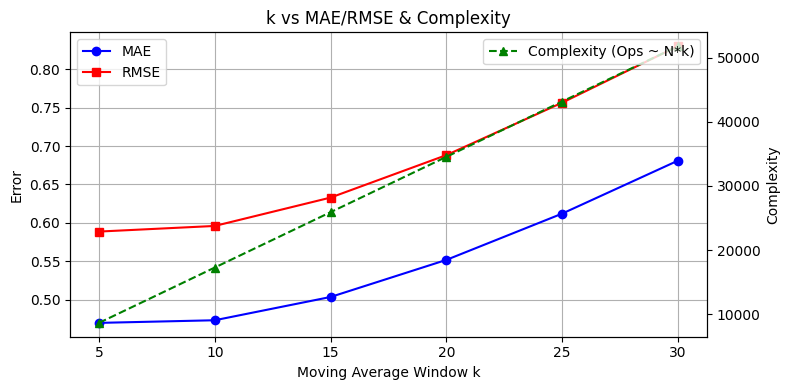

k= 5  MAE=0.4695  RMSE=0.5886  Complexity≈8635 ops
k=10  MAE=0.4730  RMSE=0.5959  Complexity≈17270 ops
k=15  MAE=0.5033  RMSE=0.6328  Complexity≈25905 ops
k=20  MAE=0.5516  RMSE=0.6882  Complexity≈34540 ops
k=25  MAE=0.6119  RMSE=0.7565  Complexity≈43175 ops
k=30  MAE=0.6810  RMSE=0.8302  Complexity≈51810 ops


In [30]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    # Moving Average 계산
    ma_pred = []
    for i in range(k, len(test_true)):  # ✅ test_true로 수정
        ma_pred.append(np.mean(test_true[i-k:i]))

    # k step 이후만 비교
    true_vals_ma = test_true[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # 연산 복잡도: N * k
    complexity = len(test_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

# ✅ MAE/RMSE vs Complexity 시각화
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# ✅ 복잡도(Ops ~ N*k)
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

# ✅ 결과 출력
for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")
